In [1]:
#!pip install -r requirements.txt

In [2]:
!python -V

Python 3.10.12


In [3]:
import os
from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv(), override=True)


True

# Setup LLM

In [4]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(
    api_key=os.getenv("DASHSCOPE_API_KEY"),
    base_url="https://dashscope.aliyuncs.com/compatible-mode/v1",
    model="qwen-plus",
    # other params...
)

messages = [
    ("system", "你是一名专业的翻译家，可以将用户的中文翻译为英文。"),
    ("human", "我喜欢编程。"),
]
llm.invoke(messages)

AIMessage(content='I like programming.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 4, 'prompt_tokens': 30, 'total_tokens': 34, 'completion_tokens_details': None, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'qwen-plus', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-26a3abf3-9ee2-4000-8db4-25e86b8b6242-0', usage_metadata={'input_tokens': 30, 'output_tokens': 4, 'total_tokens': 34, 'input_token_details': {'cache_read': 0}, 'output_token_details': {}})

# load PDF documents, skip it if already saved into chroma DB

In [5]:
import os
import shutil

# 设置持久化目录路径
persist_directory = "./db"

# 如果持久化目录存在，则清空其内容，但保留空的 ./db 文件夹
if os.path.exists(persist_directory):
    for root, dirs, files in os.walk(persist_directory, topdown=False):
        for name in files:
            file_path = os.path.join(root, name)
            os.remove(file_path)
        for name in dirs:
            dir_path = os.path.join(root, name)
            os.rmdir(dir_path)
else:
    # 如果目录不存在，则创建它
    os.makedirs(persist_directory)

# 确保持久化目录可写
os.chmod(persist_directory, 0o777)  # 调整权限以便写入

In [6]:
#manual delete the ./db folder from colab first
from ingestion import load_documents_to_db
vectordb = load_documents_to_db()

Successfully loaded: ./docs/02.pdf
Successfully loaded: ./docs/03.pdf
Successfully loaded: ./docs/01.pdf
Successfully loaded: ./docs/04.pdf
Loaded 88 PDF documents.
Total number of splits: 109


In [14]:
question = "有什麼西式美食推薦？"

docs_ss = vectordb.similarity_search(question, k=3)
docs_mmr = vectordb.max_marginal_relevance_search(question, k=2, fetch_k=3)

In [15]:
docs_ss

[Document(id='dcb6ecfc-aef5-4b4c-8c52-8b01b059dd1e', metadata={'page': 6, 'source': './docs/04.pdf'}, page_content='1110\n小店美食\n13  添好運點心專門店\n全球最便宜的米芝蓮星級餐廳之一，雖然在台\n灣已經開了多間分店，但要品嚐正港風味的點\n心，還是要到本地的街坊小店。菜單上的選擇\n或許不如茶樓多，但價格親民，招牌點心酥皮\n焗叉燒包，保證讓人一試愛上。\n地址：深水埗福榮街9至11號 \n電話：+852 2788 1226\n網址：www.timhowan.com.hk\n14  新香園\n來到這家老字號茶餐廳，必吃「蛋牛治」（雞\n蛋牛肉三明治），做法簡單卻無比美味。此\n外，千萬別錯過他們的豬手麵和港式奶茶，奶\n茶要無糖還是加奶皆可。\n地址：深水埗桂林街38號\n電話：+852 2386 2748\n12  公和荳品廠\n公和荳品廠於1960年代起扎根深水埗。這家老\n店販售各式各樣的豆製產品，多年來廣受歡迎。\n招牌豆花滑嫩如絲，豆香濃郁。這裡的自製油豆\n腐、煎釀豆腐和無糖豆漿也很有名，值得一試。\n地址：深水埗北河街118號 \n電話：+852 2386 6871\n深水埗向來是庶民美食天堂，眾多餐廳、小吃店提供簡單而實在的滋味，經濟便捷。\n從傳統麵食到創意甜點，你能用實惠的價格，盡情大啖港式佳餚。\n簡單好滋味\n小店美食'),
 Document(id='cb8b0ce6-b02f-4c14-aca2-89e9c79a60b7', metadata={'page': 10, 'source': './docs/04.pdf'}, page_content='1918\n小店美食\n27  椰汁大王\n椰汁大王的椰汁飲料風行大街\n小巷，連鎖店遍佈全港。這裡\n的椰汁採用泰國或馬來西亞椰\n子榨成，現點現做，味道清新\n香甜，跟街頭小吃是絕配。\n地址：深水埗桂林街42至\n           44號\n電話：+852 6623 9293\n28  囍囍美食\n囍囍美食位於熱鬧的小吃集中地 ── 桂林街與福榮街交界。有別於附近同類型的小吃店，囍囍的選\n擇眾多，除了常見的咖哩魚蛋、格仔餅，還有炸魚肉燒賣、豬腸和五香

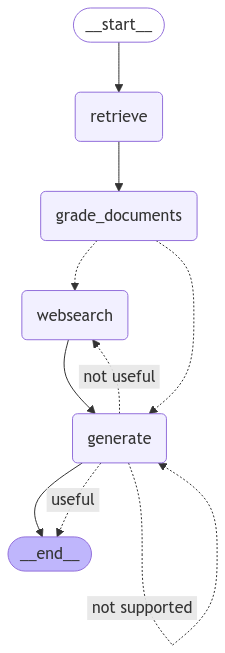

In [ ]:
from langgraph.graph import END, StateGraph

from graph.chains.answer_grader import answer_grader
from graph.chains.hallucination_grader import hallucination_grader
from graph.chains.router import RouteQuery, question_router
from graph.consts import GENERATE, GRADE_DOCUMENTS, RETRIEVE, WEBSEARCH
from graph.nodes import generate, grade_documents, retrieve, web_search
from graph.state import GraphState
from graph.graph import decide_to_generate, grade_generation_grounded_in_documents_and_question, route_question
from IPython.display import Image

workflow = StateGraph(GraphState)

workflow.add_node(RETRIEVE, retrieve)
workflow.add_node(GRADE_DOCUMENTS, grade_documents)
workflow.add_node(GENERATE, generate)
workflow.add_node(WEBSEARCH, web_search)

# workflow.set_entry_point(RETRIEVE)
workflow.set_conditional_entry_point(
    route_question,
    {
        WEBSEARCH: WEBSEARCH,
        RETRIEVE: RETRIEVE,
    },
)
workflow.add_edge(RETRIEVE, GRADE_DOCUMENTS)
workflow.add_conditional_edges(
    GRADE_DOCUMENTS,
    decide_to_generate,
    {
        WEBSEARCH: WEBSEARCH,
        GENERATE: GENERATE,
    },
)

workflow.add_conditional_edges(
    GENERATE,
    grade_generation_grounded_in_documents_and_question,
    {
        "not supported": GENERATE,
        "useful": END,
        "not useful": WEBSEARCH,
    },
)
workflow.add_edge(WEBSEARCH, GENERATE)
workflow.add_edge(GENERATE, END)

app = workflow.compile()

app.get_graph().draw_mermaid_png(output_file_path="graph.png")

# 显示本地保存的图像文件
Image(filename='graph.png')


In [17]:
print("go to documents first")
print(app.invoke(input={"question": "有什麼西式美食推薦？"}))

go to documents first
---RETRIEVE---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: NOT ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, INCLUDE WEB SEARCH---
---WEB SEARCH---
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---
---GENERATE---
---CHECK HALLUCINATIONS---


BadRequestError: Error code: 400 - {'error': {'code': 'RequestTimeOut', 'param': None, 'message': 'Request timed out, please try again later.', 'type': 'RequestTimeOut'}, 'id': 'chatcmpl-f5193da4-555c-9c6c-ad3d-30e39885118a', 'request_id': 'f5193da4-555c-9c6c-ad3d-30e39885118a'}

In [ ]:
print("go to websearch directly")
print(app.invoke(input={"question": "什么是长城？"}))

go to websearch directly
---ROUTE QUESTION---
---ROUTE QUESTION TO WEB SEARCH---
---WEB SEARCH---
---GENERATE---
---CHECK HALLUCINATIONS---


BadRequestError: Error code: 400 - {'error': {'code': 'RequestTimeOut', 'param': None, 'message': 'Request timed out, please try again later.', 'type': 'RequestTimeOut'}, 'id': 'chatcmpl-5324e49b-9303-9928-8a8b-97ae769e7bfb', 'request_id': '5324e49b-9303-9928-8a8b-97ae769e7bfb'}

# New section